<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/transfer_learning_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-06-02 07:57:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-02 07:57:32 (55.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
#helper function

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

--2022-06-02 07:57:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   257MB/s    in 5.9s    

2022-06-02 07:57:41 (261 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
import tensorflow as tf


In [5]:
IMG_size=(224,224)
train_data_all_10p=tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_size,shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


model outline
1- create a modelcheck point
2- data augmentation
3- create a base model with efficienNetB0

In [6]:
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor="val_acuuracy",save_best_only=True)

In [7]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing


In [8]:
data_augmentation=tf.keras.models.Sequential([
preprocessing.RandomFlip("horizontal"),
preprocessing.RandomRotation(0.2),
preprocessing.RandomHeight(0.2),
preprocessing.RandomWidth(0.2),
preprocessing.RandomZoom(0.2),
# preprocessing.Rescaling(1/255.) for rescaling
],name="data_augmentation")

In [9]:
#base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x= layers.GlobalAveragePooling2D(name="global_avg_pool2D")(x)
outputs=layers.Dense(len(train_data_all_10p.class_names),activation="softmax",name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)


16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool2D (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [12]:
history_all=model.fit(train_data_all_10p,epochs=5,validation_data=test_data,validation_steps=(0.15*len(test_data)),callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 91s 314ms/step - loss: 3.4623 - accuracy: 0.2519 - val_loss: 2.6707 - val_accuracy: 0.3805
Epoch 2/5
237/237 [==============================] - 59s 247ms/step - loss: 2.3477 - accuracy: 0.4606 - val_loss: 2.2032 - val_accuracy: 0.4619
Epoch 3/5
237/237 [==============================] - 53s 222ms/step - loss: 1.9763 - accuracy: 0.5365 - val_loss: 2.0487 - val_accuracy: 0.4803
Epoch 4/5
237/237 [==============================] - 51s 212ms/step - loss: 1.7535 - accuracy: 0.5704 - val_loss: 1.9632 - val_accuracy: 0.4953
Epoch 5/5
237/237 [==============================] - 48s 200ms/step - loss: 1.6042 - accuracy: 0.6129 - val_loss: 1.9611 - val_accuracy: 0.4800


In [13]:
feature_result=model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.7278 - accuracy: 0.5462


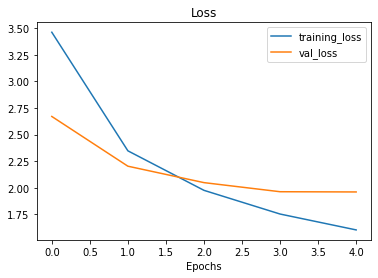

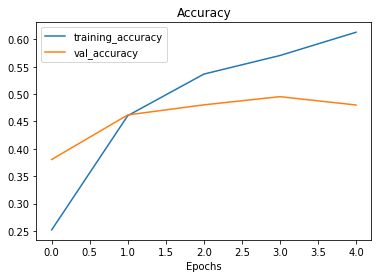

In [14]:
plot_loss_curves(history_all)

#fine tuning

In [15]:
#unfreeze all the layers
base_model.trainable=True
#refreeze every layers expect 5 last layers
for layer in base_model.layers[:-5]:
  layer.trainable=False;

In [16]:
fine_tune_epochs = 10

In [17]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(0.0001),metrics=["accuracy"])

In [18]:
history_fine=model.fit(train_data_all_10p,epochs=fine_tune_epochs,validation_data=test_data,validation_steps=(0.15*len(test_data)),initial_epoch=history_all.epoch[-1])

Epoch 5/10
237/237 [==============================] - 54s 200ms/step - loss: 1.3575 - accuracy: 0.6496 - val_loss: 1.8955 - val_accuracy: 0.5018
Epoch 6/10
237/237 [==============================] - 42s 178ms/step - loss: 1.2457 - accuracy: 0.6727 - val_loss: 1.8908 - val_accuracy: 0.5060
Epoch 7/10
237/237 [==============================] - 40s 167ms/step - loss: 1.1562 - accuracy: 0.6879 - val_loss: 1.9189 - val_accuracy: 0.4995
Epoch 8/10
237/237 [==============================] - 41s 172ms/step - loss: 1.0847 - accuracy: 0.7116 - val_loss: 1.9151 - val_accuracy: 0.5018
Epoch 9/10
237/237 [==============================] - 43s 178ms/step - loss: 1.0283 - accuracy: 0.7279 - val_loss: 1.9086 - val_accuracy: 0.5060
Epoch 10/10
237/237 [==============================] - 39s 161ms/step - loss: 0.9702 - accuracy: 0.7418 - val_loss: 1.8960 - val_accuracy: 0.5105


In [19]:
fine_tune_result=model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.6185 - accuracy: 0.5747


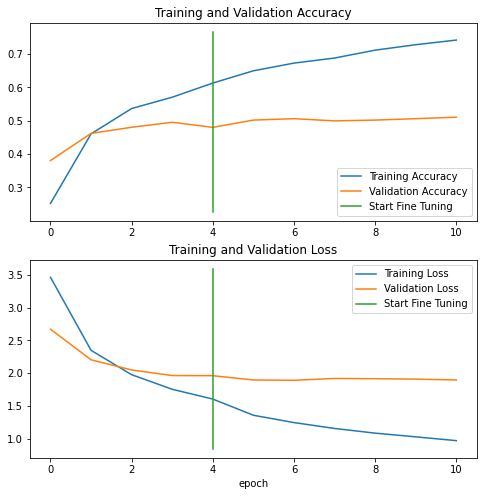

In [20]:
compare_historys(original_history=history_all,
                 new_history=history_fine,
                 initial_epochs=5)

In [21]:
#saving our model
model.save("drive/MyDrive/101_food_classes_10p")

INFO:tensorflow:Assets written to: drive/MyDrive/101_food_classes_10p/assets


#evaluating our model


In [22]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)



--2022-06-02 08:11:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   177MB/s    in 0.3s    

2022-06-02 08:11:20 (177 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [23]:
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [24]:
result_downloaded_model=model.evaluate(test_data)

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


#Making predictions 

In [25]:
pred_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 62s 77ms/step


In [26]:
len(pred_probs)

25250

In [32]:
pred_probs[0],len(pred_probs[0])

(array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
        8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
        1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
        6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
        1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
        8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
        2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
        8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
        3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
        8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
        3.5306122e-05, 3.2489035e-05, 6.7314730e

In [34]:
# we get one prediction probability for per class 

In [36]:
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

What prediction probability sample 0 looks like:
 [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 1.0569904e-06 2.1293351e-06
 3.7637546e-05 7.5972999e-0

In [38]:
pred_classes=pred_probs.argmax(axis=1)

In [41]:
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [43]:
# to get our class names , we need to unravel the test_data , bathdataset
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
  

In [46]:
len(y_labels)

25250

#Evaluating model's prediction

In [48]:
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_true=y_labels,y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
#episod13